In [1]:
import tensorflow as tf

import PIL
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sklearn
from sklearn.model_selection import train_test_split

import itertools
from typing import List, Tuple
import copy
import seaborn as sns
import unicodedata
import re
import numpy as np
import cv2 as cv
import os
import io
from skimage.io import imread
import time
from ast import literal_eval
import math
from matplotlib.path import Path
from collections import defaultdict
from statistics import median, mean

import numpy
from PIL import Image, ImageDraw
import keras
from keras import optimizers
from keras.preprocessing.image import load_img
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model

from scipy.spatial import ConvexHull, convex_hull_plot_2d

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Parse and Load Dataset

In [11]:
TARGET_SIZE = (640, 360)
IMAGE_EXAMPLE_SHAPE = TARGET_SIZE + (3,)

LANDMARK_EXAMPLE_SHAPE = (39, )

BASE_PATH = '/home/lancecotingkeh/aggregated/'
LABEL_TO_ENCODING = {'proper': 0, 'crooked': 1, 'lockout': 2, 'rounded': 3, 'squat': 4}
NUM_CLASSES = len(LABEL_TO_ENCODING)

In [12]:
min_x, max_x, min_y, max_y = (0.0, 652.3190116882324, 10.059281587600708, 341.7217969894409)
xy = [(max_y, min_x),(max_y, max_x),(min_y, max_x),(min_y, min_x)]

In [13]:
df_metadata = pd.read_csv('/home/lancecotingkeh/aggregated/pose_landmarks.csv')

In [14]:
df_metadata.head(3)

,relative_image_path,data_split,label,landmark_nose,landmark_left_shoulder,landmark_right_shoulder,landmark_left_elbow,landmark_right_elbow,landmark_left_wrist,landmark_right_wrist,landmark_left_hip,landmark_right_hip,landmark_left_knee,landmark_right_knee,landmark_left_ankle,landmark_right_ankle
0,5_lockout/lyron_deg135_take2/frame46.jpg,train,proper,"(0.8408212661743164, 0.44535547494888306, -0.6...","(0.7523922920227051, 0.483453631401062, -0.080...","(0.59047532081604, 0.4363204836845398, -0.5876...","(0.7419312596321106, 0.6247938871383667, 0.025...","(0.5161336064338684, 0.5835246443748474, -0.57...","(0.7500355839729309, 0.7468990683555603, -0.06...","(0.5082715749740601, 0.7348905205726624, -0.60...","(0.4615359604358673, 0.5611119866371155, 0.148...","(0.34500354528427124, 0.5380272269248962, -0.1...","(0.701583981513977, 0.6245787739753723, -0.039...","(0.5147499442100525, 0.576558530330658, -0.833...","(0.6168646812438965, 0.8138770461082458, 0.163...","(0.4869398772716522, 0.7884341478347778, -0.77..."
1,5_lockout/lyron_deg135_take2/frame203.jpg,train,proper,"(0.8654815554618835, 0.4472369849681854, -0.59...","(0.7866912484169006, 0.5048587322235107, -0.12...","(0.6134108901023865, 0.4505915343761444, -0.55...","(0.7522295713424683, 0.6383607983589172, -0.09...","(0.5366990566253662, 0.5983656644821167, -0.55...","(0.7443258762359619, 0.7658225893974304, -0.16...","(0.5270508527755737, 0.7469443678855896, -0.51...","(0.49029654264450073, 0.565066397190094, 0.141...","(0.3752322196960449, 0.5404682159423828, -0.14...","(0.721193253993988, 0.6225733160972595, 0.0097...","(0.604214072227478, 0.5913941860198975, -0.544...","(0.6175094246864319, 0.7968677282333374, 0.155...","(0.4880143404006958, 0.7921530604362488, -0.41..."
2,5_lockout/lyron_deg135_take2/frame207.jpg,train,proper,"(0.8618521690368652, 0.42703595757484436, -0.5...","(0.7759232521057129, 0.48765045404434204, -0.0...","(0.6108279228210449, 0.43047401309013367, -0.4...","(0.7476211786270142, 0.6245181560516357, 0.032...","(0.526120126247406, 0.5700463652610779, -0.489...","(0.7355574369430542, 0.7427244186401367, -0.06...","(0.5221640467643738, 0.7184542417526245, -0.49...","(0.4879094958305359, 0.5496541261672974, 0.132...","(0.37393078207969666, 0.5203757286071777, -0.1...","(0.7107850313186646, 0.6180444359779358, 0.138...","(0.574447512626648, 0.5620325207710266, -0.697...","(0.5569970607757568, 0.7731618285179138, 0.340...","(0.47665083408355713, 0.7690679430961609, -0.6..."


In [15]:
landmark_columns = [col for col in df_metadata if col.startswith('landmark_')]
landmark_columns

['landmark_nose',
 'landmark_left_shoulder',
 'landmark_right_shoulder',
 'landmark_left_elbow',
 'landmark_right_elbow',
 'landmark_left_wrist',
 'landmark_right_wrist',
 'landmark_left_hip',
 'landmark_right_hip',
 'landmark_left_knee',
 'landmark_right_knee',
 'landmark_left_ankle',
 'landmark_right_ankle']

In [16]:
def load_preprocess_imgs(image_paths: List[str]) -> np.ndarray:
    images = []
    for image_path in image_paths:
        img = load_img(image_path, target_size=TARGET_SIZE)        
        
#         mask = Image.new("L", img.size, 3)
#         draw = ImageDraw.Draw(mask)
#         draw.polygon(xy, fill=255, outline=None)
#         black =  Image.new("L", img.size, 3)
#         img = Image.composite(img, black, mask)

        np_img = np.asarray(img)
        
#         print(np_img.shape)

        assert np_img.shape == IMAGE_EXAMPLE_SHAPE, f'errro shape: {np_img.shape}'
        
        images.append(np_img)
        
        # horizontal flip both image
        horizontal_flipped_img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        np_img = np.asarray(img)
        images.append(np_img)
        
    return np.array(images)

In [17]:
def load_preprocess_landmarks(df_metadata) -> np.ndarray:
    landmark_examples = []
    
    x_y_only = []
    
    for row in df_metadata.iterrows():
        single_example = []
        flipped_example = []
        
        for landmark in landmark_columns:
            x, y, z = literal_eval(row[1][landmark])
            
            single_example.extend([x, y, z])
            
            x_y_only.append([x, y])
            
            # horizontal flip landmark
            
            flipped_example.extend([1-x, y, z])
            
            x_y_only.append([1-x, y])
        
        landmark_examples.append(np.array(single_example))
        landmark_examples.append(np.array(flipped_example))
    return np.array(landmark_examples), np.array(x_y_only)

In [18]:
def interleave_np_arrays(a, b):
    a_shape = a.shape
    c = np.empty((a_shape[0] * 2, a_shape[1]), dtype=a.dtype)
    c[0::2] = a
    c[1::2] = b
    
    return c

In [19]:
# load training data

df_train = df_metadata[df_metadata['data_split'] == 'train']
X_train_imgs = load_preprocess_imgs([f'{BASE_PATH}{p}' for p in df_train['relative_image_path']])
X_train_landmarks, X_train_x_y = load_preprocess_landmarks(df_train)
Y_train = keras.utils.to_categorical([LABEL_TO_ENCODING[l] for l in df_train['label']], 5)
Y_train = interleave_np_arrays(Y_train, Y_train)

In [20]:
len(df_train), len(X_train_imgs), len(X_train_landmarks), len(Y_train)

(589, 1178, 1178, 1178)

In [21]:
X_train_imgs[0].shape

(640, 360, 3)

In [22]:
# load validation data
df_val = df_metadata[df_metadata['data_split'] == 'val']
X_val_imgs = load_preprocess_imgs([f'{BASE_PATH}{p}' for p in df_val['relative_image_path']])
X_val_landmarks, X_val_x_y = load_preprocess_landmarks(df_val)
Y_val = keras.utils.to_categorical([LABEL_TO_ENCODING[l] for l in df_val['label']], 5)
Y_val = interleave_np_arrays(Y_val, Y_val)

In [23]:
len(df_val), len(X_val_imgs), len(X_val_landmarks), len(Y_val)

(100, 200, 200, 200)

In [24]:
# load test data
df_test = df_metadata[df_metadata['data_split'] == 'test']
X_test_imgs = load_preprocess_imgs([f'{BASE_PATH}{p}' for p in df_test['relative_image_path']])
X_test_landmarks, X_test_x_y  = load_preprocess_landmarks(df_test)
Y_test = keras.utils.to_categorical([LABEL_TO_ENCODING[l] for l in df_test['label']], 5)
Y_test = interleave_np_arrays(Y_test, Y_test)

In [25]:
len(df_test), len(X_test_imgs), len(X_test_landmarks), len(Y_test)

(200, 400, 400, 400)

In [26]:
IMAGE_EXAMPLE_SHAPE

(640, 360, 3)

In [27]:
X_train_x_y.shape, X_val_x_y.shape, X_test_x_y.shape

((15314, 2), (2600, 2), (5200, 2))

# Convex Hull of Pose x,y

In [28]:
all_x_y = np.concatenate([X_train_x_y, X_val_x_y, X_test_x_y])

In [29]:
all_x_y.shape

(23114, 2)

In [30]:
x_y_targets = all_x_y
hull = ConvexHull(x_y_targets)

In [31]:
import matplotlib.pyplot as plt

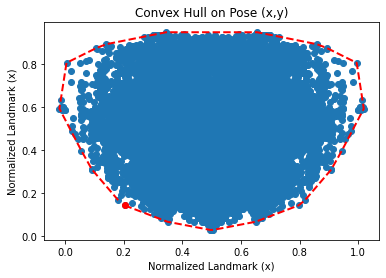

In [52]:
plt.plot(x_y_targets[:,0], x_y_targets[:,1], 'o')
plt.plot(x_y_targets[hull.vertices,0], x_y_targets[hull.vertices,1], 'r--', lw=2)
plt.plot(x_y_targets[hull.vertices[0],0], x_y_targets[hull.vertices[0],1], 'ro')
plt.xlabel('Normalized Landmark (x)')
plt.ylabel('Normalized Landmark (x)')
plt.title('Convex Hull on Pose (x,y)')
plt.show()

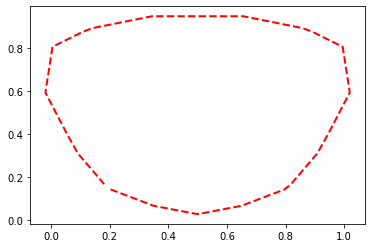

In [33]:
plt.plot(x_y_targets[hull.vertices,0], x_y_targets[hull.vertices,1], 'r--', lw=2)

In [34]:
x_y_targets[hull.vertices, 0], x_y_targets[hull.vertices,1]

(array([ 0.20312095,  0.34980771,  0.49503642,  0.50496358,  0.65019229,
         0.79687905,  0.81867091,  0.90646994,  0.90906334,  0.94462991,
         1.01924846,  1.01463145,  0.99503717,  0.89291447,  0.85889572,
         0.65560144,  0.34439856,  0.14110428,  0.10708553,  0.00496283,
        -0.01463145, -0.01924846,  0.05537009,  0.09093666,  0.09353006,
         0.18132909]),
 array([0.14219856, 0.06595442, 0.02794245, 0.02794245, 0.06595442,
        0.14219856, 0.16648409, 0.30662018, 0.3113299 , 0.39798585,
        0.59318608, 0.63505799, 0.80665731, 0.87592912, 0.89364749,
        0.94922721, 0.94922721, 0.89364749, 0.87592912, 0.80665731,
        0.63505799, 0.59318608, 0.39798585, 0.3113299 , 0.30662018,
        0.16648409]))

In [35]:
def mask_from_contours(ref_img, contours):
    mask = np.zeros(ref_img.shape, np.uint8)
    mask = cv2.drawContours(mask, contours, -1, (255,255,255), -1)
    return cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)


In [36]:
# contours

In [37]:
contours = np.array(list(zip(x_y_targets[hull.vertices, 0],x_y_targets[hull.vertices, 1])))

contours[:, 0] = contours[:, 0]* IMAGE_EXAMPLE_SHAPE[0]
contours[:, 1] = contours[:, 1]* IMAGE_EXAMPLE_SHAPE[1]

In [38]:
contours[contours<=0] = 0

In [39]:
contours

array([[129.99740601,  51.19148254],
       [223.87693405,  23.74359012],
       [316.82331085,  10.05928159],
       [323.17668915,  10.05928159],
       [416.12306595,  23.74359012],
       [510.00259399,  51.19148254],
       [523.94938469,  59.93427157],
       [580.14076233, 110.38326502],
       [581.80053711, 112.07876444],
       [604.56314087, 143.27490449],
       [652.31901169, 213.54698896],
       [649.36412811, 228.62087488],
       [636.82378769, 290.39663315],
       [571.46526337, 315.33448219],
       [549.69326019, 321.7130971 ],
       [419.58492279, 341.72179699],
       [220.41507721, 341.72179699],
       [ 90.30673981, 321.7130971 ],
       [ 68.53473663, 315.33448219],
       [  3.17621231, 290.39663315],
       [  0.        , 228.62087488],
       [  0.        , 213.54698896],
       [ 35.43685913, 143.27490449],
       [ 58.19946289, 112.07876444],
       [ 59.85923767, 110.38326502],
       [116.05061531,  59.93427157]])

In [40]:
contours[:, 0]

array([129.99740601, 223.87693405, 316.82331085, 323.17668915,
       416.12306595, 510.00259399, 523.94938469, 580.14076233,
       581.80053711, 604.56314087, 652.31901169, 649.36412811,
       636.82378769, 571.46526337, 549.69326019, 419.58492279,
       220.41507721,  90.30673981,  68.53473663,   3.17621231,
         0.        ,   0.        ,  35.43685913,  58.19946289,
        59.85923767, 116.05061531])

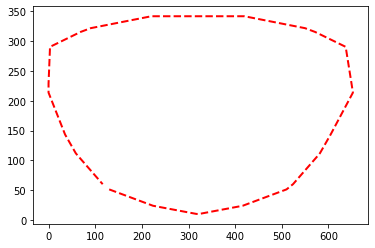

In [41]:
plt.plot(contours[:, 0], contours[:, 1], 'r--', lw=2)

In [42]:
for img, landmark in zip(X_train_imgs, X_train_landmarks):
    print(img.shape)
    print(landmark.shape)
    break

(640, 360, 3)
(39,)


In [43]:
min(landmark[0::3]), max(landmark[0::3])

(0.34500354528427124, 0.8408212661743164)

In [44]:
min(landmark[1::3]), max(landmark[1::3])

(0.4363204836845398, 0.8138770461082458)

In [45]:
min_x = min(contours[:, 0])
max_x = max(contours[:, 0])

min_y = min(contours[:, 1])
max_y = max(contours[:, 1])

In [46]:
min_x, max_x, min_y, max_y

(0.0, 652.3190116882324, 10.059281587600708, 341.7217969894409)

In [47]:
xy

[(341.7217969894409, 0.0),
 (341.7217969894409, 652.3190116882324),
 (10.059281587600708, 652.3190116882324),
 (10.059281587600708, 0.0)]

In [48]:
xy = [(max_y, min_x),(max_y, max_x),(min_y, max_x),(min_y, min_x)]
xy

[(341.7217969894409, 0.0),
 (341.7217969894409, 652.3190116882324),
 (10.059281587600708, 652.3190116882324),
 (10.059281587600708, 0.0)]

In [49]:
# img
img = load_img('/home/lancecotingkeh/aggregated/1_proper/amol_deg45_take1/frame40.jpg', target_size=TARGET_SIZE)

# xy = [(max_y, min_x),(min_y, max_x),(max_y, max_x),(min_y, min_x)]

mask = Image.new("L", img.size, 0)
draw = ImageDraw.Draw(mask)
draw.polygon(xy, fill=255, outline=None)
black =  Image.new("L", img.size, 0)
result = Image.composite(img, black, mask)

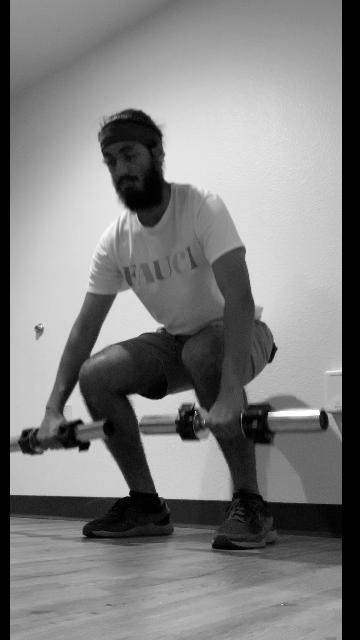

In [50]:
result

In [44]:
# X_train_imgs_masked = []

# for img in X_train_imgs:
#     img *= stacked_mask
#     X_train_imgs_masked.append(img)




In [45]:
# Image.fromarray(X_train_imgs_masked[70])

In [46]:
# X_train_imgs_masked

# Define Layers

In [47]:
initializer = tf.initializers.VarianceScaling(scale=2.0)

class ConvGroupLayer(tf.keras.layers.Layer):
    def __init__(self, channel_size: int, filter_size: Tuple[int, int], dropout_rate: float):
        self.conv = Conv2D(channel_size, filter_size, padding='same', kernel_initializer=initializer)
        self.max_pool = MaxPooling2D(filter_size)
        self.bn = BatchNormalization(axis=-1)
        self.relu = LeakyReLU(alpha=0.1)
        self.drop_out = Dropout(dropout_rate)
    
    def __call__(self, x):
        x = self.conv(x)
        x = self.max_pool(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.drop_out(x)
        
        return x

class CNNTower(tf.keras.layers.Layer):
    def __init__(self, num_conv_layers:int, initial_channel_size: int, initial_filter_size: Tuple[int, int], dropout_rate: float):
        self.initial_conv = Conv2D(initial_channel_size, initial_filter_size, padding='same', kernel_initializer=initializer, input_shape=IMAGE_EXAMPLE_SHAPE)
        self.initial_max_pool = MaxPooling2D(initial_filter_size, padding='same')
        self.initial_bn = BatchNormalization(axis=-1)
        self.initial_relu = LeakyReLU(alpha=0.1)
        self.initial_drop_out = Dropout(dropout_rate)
        
        self.intermediate_conv_layers = []
        
        for idx in range(num_conv_layers):
            channel_size = initial_channel_size//(2**(idx+1))
            
            self.intermediate_conv_layers.append(ConvGroupLayer(channel_size, initial_filter_size, dropout_rate))
            
    def __call__(self, x):
        x = self.initial_conv(x)
        x = self.initial_max_pool(x)
        x = self.initial_bn(x)
        x = self.initial_relu(x)
        x = self.initial_drop_out(x)
        
        for layer in self.intermediate_conv_layers:
            x = layer(x)
            
        return Flatten()(x)
            
        
        
        
        

In [48]:
# cnn_tower = CNNTower(num_conv_layers = 3,
#                      initial_channel_size = 128,
#                      initial_filter_size = (3, 3),
#                      dropout_rate = 0.20
#                     )
# cnn_tower(tf.random.uniform((32, 640, 360, 3), dtype=tf.float32, minval=0, maxval=256))

In [49]:
class DNN(tf.keras.layers.Layer):
    def __init__(self, num_layers: int, initial_dense_size: int, dropout_rate: float):
        self.layers = []
        
        for idx in range(num_layers):
            self.layers.append(Dense(initial_dense_size//(2**idx)))
            self.layers.append(tf.keras.layers.BatchNormalization())
            self.layers.append(LeakyReLU(alpha=0.1))
            
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x
            
            
    

In [50]:
# dnn = DNN(3, 256, 0.2)
# dnn(tf.random.uniform((32, 488), dtype=tf.float32))

# Two Tower Input Model

In [51]:
image_input = Input(shape=IMAGE_EXAMPLE_SHAPE)
cnn_tower = CNNTower(num_conv_layers = 3,
                     initial_channel_size = 128,
                     initial_filter_size = (3, 3),
                     dropout_rate = 0.20
                    )
x_cnn_tower = cnn_tower(image_input)

ValueError: Input 0 of layer conv2d is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: [None, 640, 360]

In [54]:
IMAGE_EXAMPLE_SHAPE

(640, 360)

In [52]:
landmark_input = Input(shape=LANDMARK_EXAMPLE_SHAPE)
dnn_tower = DNN(3, 1024, 0.2)

x_dnn_tower = dnn_tower(landmark_input)

In [53]:
x = concatenate([x_cnn_tower, x_dnn_tower])

NameError: name 'x_cnn_tower' is not defined

In [ ]:
output_tower = DNN(3, 256, 0.2)
x = output_tower(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

In [ ]:
model = Model(inputs=[image_input, landmark_input], outputs=[output])

In [ ]:
opt = optimizers.Adam()

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
# model.summary()

In [ ]:
epochs = 100
batch_size = 32

In [ ]:
model.fit([X_train_imgs, X_train_landmarks], Y_train,
          batch_size=batch_size,
          epochs=epochs,
#           callbacks=callbacks,
          verbose=1,
          validation_data=([X_val_imgs, X_val_landmarks], Y_val),
          shuffle=True)

In [ ]:
model.evaluate([X_test_imgs, X_test_landmarks], Y_test, verbose=1)

In [ ]:
Y_preds = model.predict([X_test_imgs, X_test_landmarks])

In [ ]:
Y_test_labels = np.argmax(Y_test, axis=-1)
Y_preds_labels = np.argmax(Y_preds, axis=-1)

In [ ]:
print(sklearn.metrics.classification_report(Y_test_labels, Y_preds_labels))

# [Ablation] Image only

In [ ]:
image_input = Input(shape=IMAGE_EXAMPLE_SHAPE)
cnn_tower = CNNTower(num_conv_layers = 3,
                     initial_channel_size = 128,
                     initial_filter_size = (3, 3),
                     dropout_rate = 0.20
                    )
x_cnn_tower = cnn_tower(image_input)

In [ ]:
output_tower = DNN(3, 256, 0.2)
x = output_tower(x_cnn_tower)
output = Dense(NUM_CLASSES, activation='softmax')(x)

In [ ]:
ablation_model_image = Model(inputs=[image_input], outputs=[output])

In [ ]:
opt = optimizers.Adam()

ablation_model_image.compile(loss='categorical_crossentropy',
                             optimizer=opt,
                             metrics=['accuracy'])

In [ ]:
epochs = 100
batch_size = 32

In [ ]:
ablation_model_image.fit([X_train_imgs], Y_train,
                         batch_size=batch_size,
                         epochs=epochs,
#                          callbacks=callbacks,
                         verbose=1,
                         validation_data=([X_val_imgs], Y_val),
                         shuffle=True)

In [ ]:
Y_preds = ablation_model_image.predict([X_test_imgs, X_test_landmarks])

In [ ]:
Y_test_labels = np.argmax(Y_test, axis=-1)
Y_preds_labels = np.argmax(Y_preds, axis=-1)

In [ ]:
print(sklearn.metrics.classification_report(Y_test_labels, Y_preds_labels))

# [Ablation] Pose Landmarks Only

In [ ]:
landmark_input = Input(shape=LANDMARK_EXAMPLE_SHAPE)
dnn_tower = DNN(3, 1024, 0.2)

x_dnn_tower = dnn_tower(landmark_input)

In [ ]:
output_tower = DNN(3, 256, 0.2)
x = output_tower(x_dnn_tower)
output = Dense(NUM_CLASSES, activation='softmax')(x)

In [ ]:
ablation_model_landmark = Model(inputs=[landmark_input], outputs=[output])

In [ ]:
opt = optimizers.Adam()

ablation_model_landmark.compile(loss='categorical_crossentropy',
                                optimizer=opt,
                                metrics=['accuracy'])

In [ ]:
epochs = 100
batch_size = 32

In [ ]:
ablation_model_landmark.fit([X_train_landmarks], Y_train,
                            batch_size=batch_size,
                            epochs=epochs,
#                          callbacks=callbacks,
                            verbose=1,
                            validation_data=([X_val_landmarks], Y_val),
                            shuffle=True)

In [ ]:
Y_preds = ablation_model_landmark.predict([X_test_landmarks])

In [ ]:
Y_test_labels = np.argmax(Y_test, axis=-1)
Y_preds_labels = np.argmax(Y_preds, axis=-1)

In [ ]:
print(sklearn.metrics.classification_report(Y_test_labels, Y_preds_labels))